In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.pipeline import Pipeline
from itertools import combinations
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score

### Extraction Features

In [2]:
df = pd.read_csv("../PreProcessingResumes/processed_data/Resume_proc_lemm.csv")

In [3]:
tfidf_vect = TfidfVectorizer(
    lowercase=True,
    binary=False,
    max_features=10000,
    ngram_range=(1, 6),
    max_df=0.8,
    min_df=2
)

In [4]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df['Resume_str'], df['Category'], test_size=0.2, random_state=42, stratify=df['Category'])

print("Train data size:", X_train.shape)
print("Validation data size:", X_test.shape)

Train data size: (1986,)
Validation data size: (497,)


In [5]:
X_train_features = tfidf_vect.fit_transform(X_train)
X_test_features = tfidf_vect.transform(X_test)

In [6]:
len(tfidf_vect.vocabulary_)

10000

### Random Forest Classifier

In [7]:
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print(f"Model with rank: {i}")
            print(f"Mean validation score: {results['mean_test_score'][candidate]:.3f} (std: {results['std_test_score'][candidate]:.3f})")
            print(f"Parameters: {results['params'][candidate]}")
            print("")

In [8]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [9]:
class_counts = y_train.value_counts()
min_classes = class_counts[class_counts < 0.8*class_counts.mean()].index.tolist()

print(f"Applicazione di SMOTE alle classi: {min_classes}")

target_size = int(0.7*class_counts.max())
sampling_strategy = {cls: target_size for cls in min_classes}

Applicazione di SMOTE alle classi: ['ADVOCATE', 'APPAREL', 'BPO', 'AGRICULTURE', 'ARTS', 'AUTOMOBILE']


In [10]:
pipeline = Pipeline(steps=[
    #('tfidf', tfidf_vect),
    ('smote', SMOTE(sampling_strategy=sampling_strategy, random_state=42, k_neighbors=3)),      #k_neighbors a cause di category con pochi sample
    ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

In [11]:
param_grid = {
    'clf__n_estimators': [400, 700],
    'clf__max_features': ['sqrt', 'log2'],
    'clf__max_depth' : [8, 9, 10],
    'clf__criterion' : ['gini', 'entropy'],
    'clf__min_samples_split': [10],
    'clf__min_samples_leaf': [15]
}

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=skf,
    scoring='f1_weighted',
    return_train_score=True,
    n_jobs=-1
)

start = time()
grid_search = grid.fit(X_train_features, y_train)

print(f"GridSearchCV took {(time() - start):.2f} seconds for {len(grid_search.cv_results_['params'])} candidates parameter settings.\n")
report(grid_search.cv_results_)

GridSearchCV took 326.09 seconds for 24 candidates parameter settings.

Model with rank: 1
Mean validation score: 0.621 (std: 0.011)
Parameters: {'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 15, 'clf__min_samples_split': 10, 'clf__n_estimators': 700}

Model with rank: 2
Mean validation score: 0.620 (std: 0.016)
Parameters: {'clf__criterion': 'gini', 'clf__max_depth': 9, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 15, 'clf__min_samples_split': 10, 'clf__n_estimators': 400}

Model with rank: 3
Mean validation score: 0.617 (std: 0.012)
Parameters: {'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 15, 'clf__min_samples_split': 10, 'clf__n_estimators': 400}

Model with rank: 4
Mean validation score: 0.613 (std: 0.012)
Parameters: {'clf__criterion': 'gini', 'clf__max_depth': 9, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 15, 'clf__min_samples_split': 10, 'clf__n_e

In [12]:
print(grid_search.best_params_)

{'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 15, 'clf__min_samples_split': 10, 'clf__n_estimators': 700}


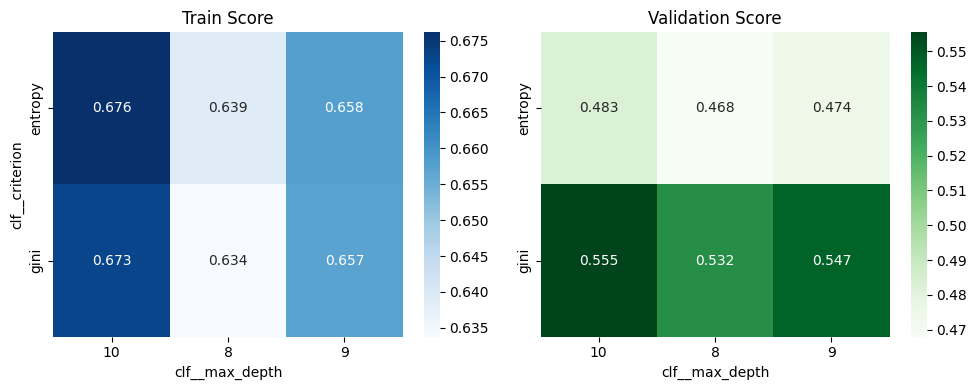

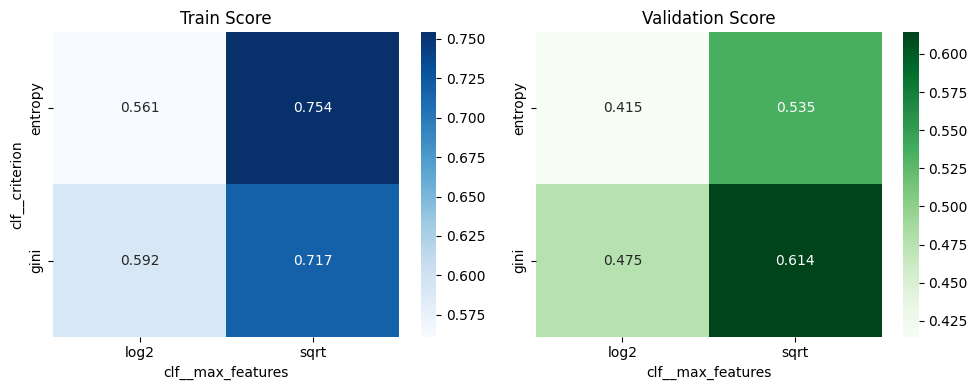

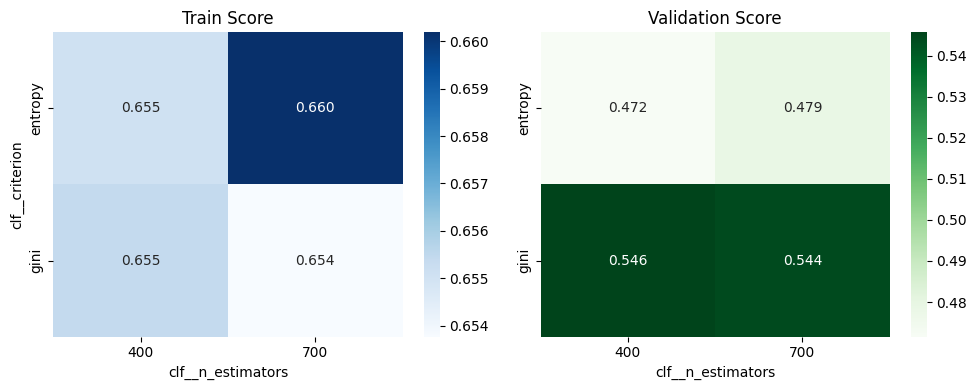

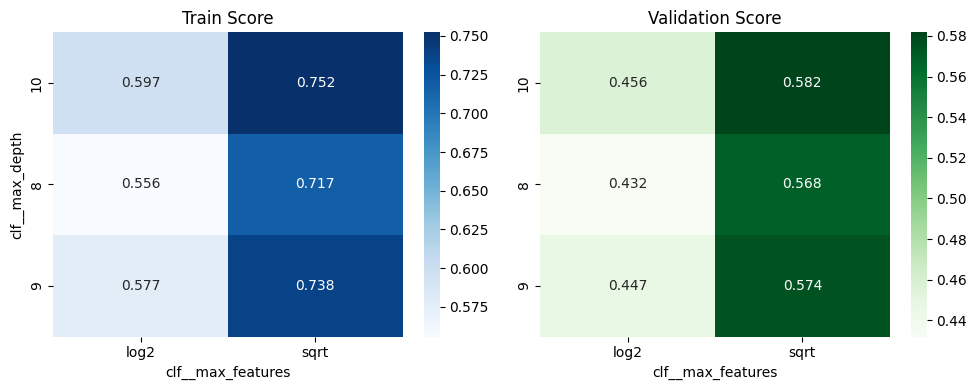

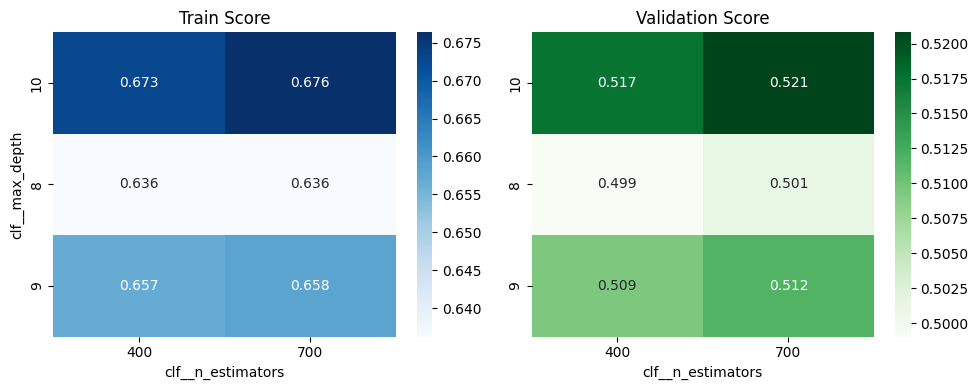

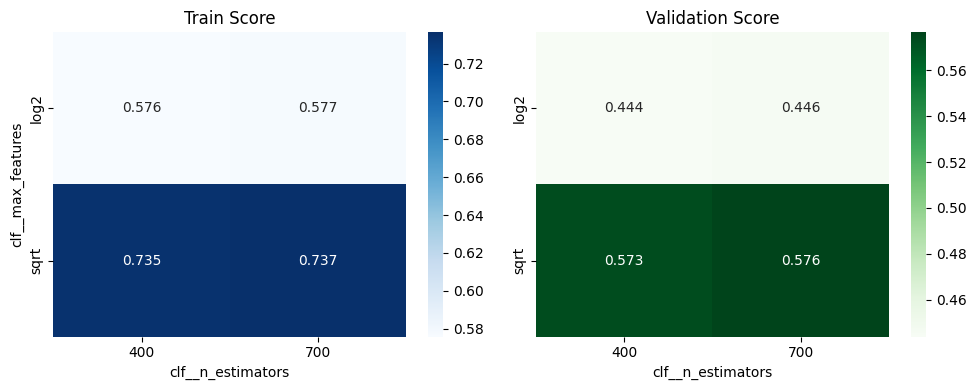

In [13]:
# DataFrame con i risultati
results = pd.DataFrame(grid_search.cv_results_)
param_cols = [col for col in results.columns if col.startswith("param_")]

# Converti tutti i parametri in stringa per la pivot table
for p in param_cols:
    results[p] = results[p].astype(str)

# Heatmap per ogni coppia di parametri
for p1, p2 in combinations(param_cols, 2):
    try:
        pivot_val = results.pivot_table(values='mean_test_score', index=p1, columns=p2)
        pivot_train = results.pivot_table(values='mean_train_score', index=p1, columns=p2)

        if pivot_val.shape[0] > 1 and pivot_val.shape[1] > 1:
            fig, axes = plt.subplots(1, 2, figsize=(10, 4))

            sns.heatmap(pivot_train, annot=True, fmt=".3f", cmap="Blues", ax=axes[0])
            axes[0].set_title(f"Train Score")
            axes[0].set_xlabel(p2.replace("param_", ""))
            axes[0].set_ylabel(p1.replace("param_", ""))

            sns.heatmap(pivot_val, annot=True, fmt=".3f", cmap="Greens", ax=axes[1])
            axes[1].set_title(f"Validation Score")
            axes[1].set_xlabel(p2.replace("param_", ""))
            axes[1].set_ylabel("")

            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Errore con {p1} e {p2}: {e}")


In [14]:
RF_Model_best = grid_search.best_estimator_
prediction = RF_Model_best.predict(X_test_features)

In [15]:
print("Training Score: {:.2f}".format(RF_Model_best.score(X_train_features, y_train)))
print("Test Score: {:.2f}".format(RF_Model_best.score(X_test_features, y_test)))

Training Score: 0.77
Test Score: 0.70


In [16]:
print(classification_report(y_test, prediction))

                        precision    recall  f1-score   support

            ACCOUNTANT       0.60      0.93      0.72        27
              ADVOCATE       0.80      0.62      0.70        13
           AGRICULTURE       0.40      0.67      0.50         6
               APPAREL       0.62      0.73      0.67        11
                  ARTS       0.00      0.00      0.00         4
            AUTOMOBILE       0.00      0.00      0.00         2
              AVIATION       0.88      0.74      0.80        19
               BANKING       1.00      0.06      0.11        18
                   BPO       0.00      0.00      0.00        10
  BUSINESS-DEVELOPMENT       0.55      0.76      0.64        34
                  CHEF       0.77      1.00      0.87        20
          CONSTRUCTION       0.91      0.91      0.91        22
            CONSULTANT       0.83      0.20      0.32        25
              DESIGNER       0.89      0.77      0.83        22
         DIGITAL-MEDIA       0.89      

<Figure size 1500x1000 with 0 Axes>

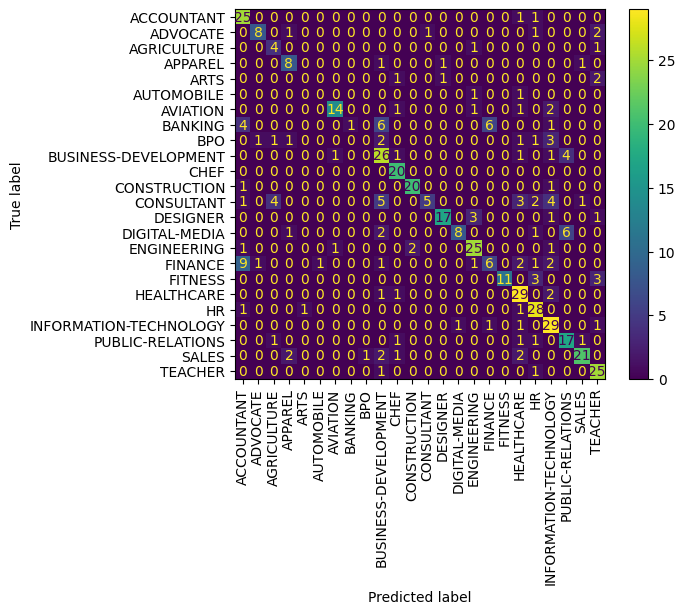

In [17]:
plt.figure(figsize=(15, 10))
ConfusionMatrixDisplay.from_predictions(y_test, prediction)
plt.xticks(rotation=90)
plt.show()

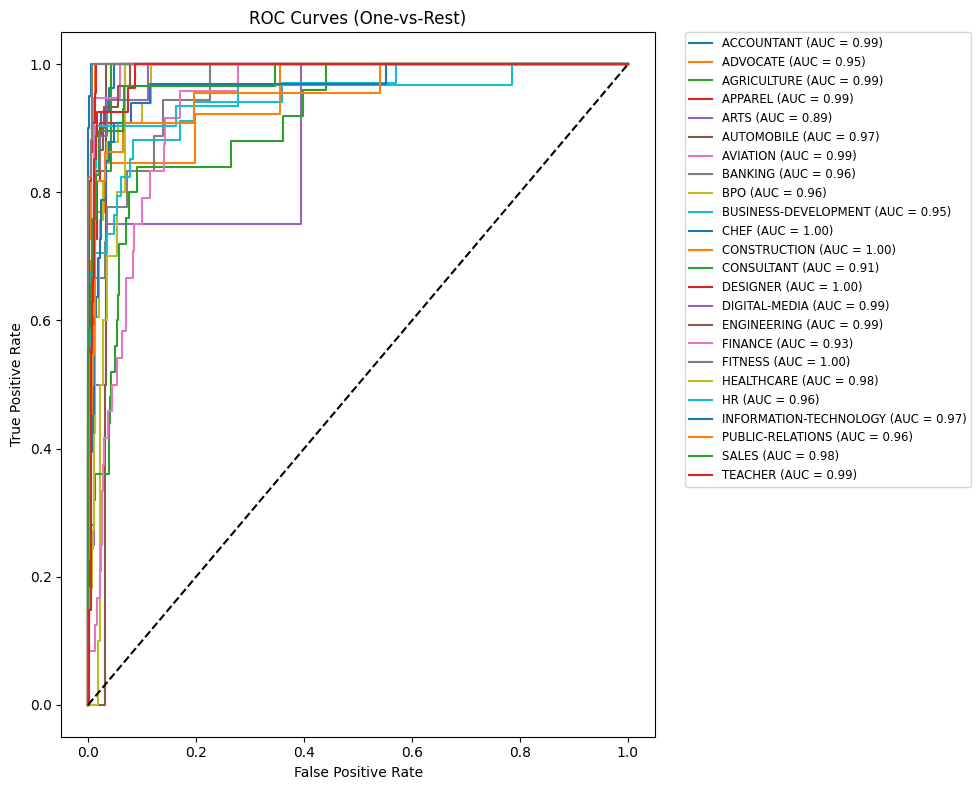

In [20]:
y_test_bin = label_binarize(y_test, classes=RF_Model_best.classes_)
y_score = RF_Model_best.predict_proba(X_test_features)

plt.figure(figsize=(10, 8))

for i in range(len(RF_Model_best.classes_)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{RF_Model_best.classes_[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")

# Sposta la legenda fuori dal grafico
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize='small')
plt.tight_layout()
plt.show()

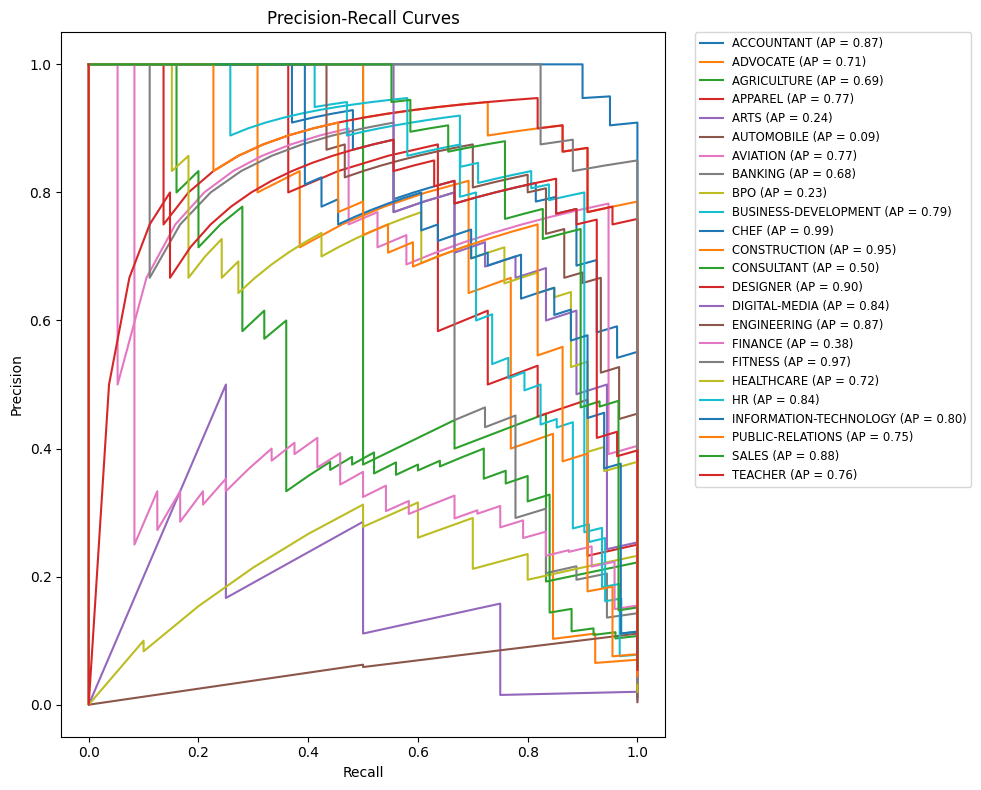

In [21]:
plt.figure(figsize=(10, 8))

for i in range(len(RF_Model_best.classes_)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    avg_precision = average_precision_score(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, label=f"{RF_Model_best.classes_[i]} (AP = {avg_precision:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")

# Legenda esterna a destra
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize='small')
plt.tight_layout()
plt.show()

In [22]:
import sys
sys.path.append('..')

from utils import save_experiment_TFIDF

save_experiment_TFIDF(tfidf_vect, grid_search, RF_Model_best, X_train_features, y_train, X_test_features, y_test)

✅ Riga di log aggiunta in 'experiment_log.txt':
RandomForestClassifier(clf__criterion=gini, clf__max_depth=10, clf__max_features=sqrt, clf__min_samples_leaf=15, clf__min_samples_split=10, clf__n_estimators=700) | TFIDF(max_features=10000, ngram_range=(1, 6), max_df=0.8, min_df=2) | Accuracy train=0.768, test=0.698

